In [142]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import plotting
from scipy.stats import norm

In [143]:
results = []
results_dir = './20231005144659_sim_mar/results/'
for filename in os.listdir(results_dir):
    with open(f'{results_dir}/{filename}', 'rb') as f:
        res = pickle.load(f).to_dict()
        res.update(res['result'])
        del res['result']
        results.append(pd.Series(res))

df = pd.DataFrame(results)
with open('./20231005144659_sim_mar/results_all.pickle', 'wb') as f:
    pickle.dump(df, f)

In [144]:
# 20231004145115_sim_mar
# 20231005144659_sim_mar
with open(f'./20231004145115_sim_mar/results_all.pickle', 'rb') as f:
    df_ours = pickle.load(f)
    df_ours_w = df_ours[df_ours['sim_setup'] == 'wasserstein'].copy()
    df_ours_r = df_ours[df_ours['sim_setup'] == 'r'].copy()


with open(f'./20231005144659_sim_mar/results_all.pickle', 'rb') as f:
    df_ser_dep = pickle.load(f)
    df_ser_dep_w = df_ser_dep[df_ser_dep['sim_setup'] == 'wasserstein'].copy()
    df_ser_dep_r = df_ser_dep[df_ser_dep['sim_setup'] == 'r'].copy()


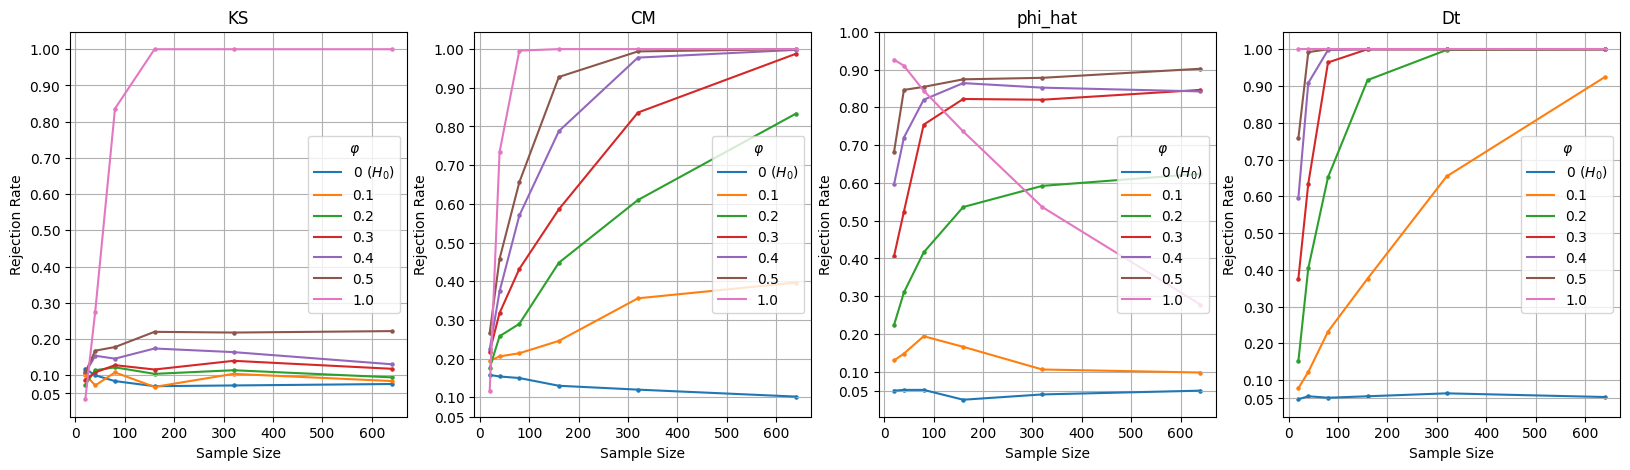

In [165]:



plt.figure(figsize=(20,5))

plt.subplot(1,4,1)
plt.title('KS')
plotting.plot_test_for(df_ser_dep_w, 'KS', onesided=True)
plt.subplot(1,4,2)
plt.title('CM')
plotting.plot_test_for(df_ser_dep_w, 'CM', onesided=True)


plt.subplot(1,4,3)
plt.title('phi_hat')
plotting.plot_test_for(df_ours_w, 'phi_hat', onesided=True)
plt.subplot(1,4,4)
plt.title('Dt')
plotting.plot_test_for(df_ours_w, 'Dt')

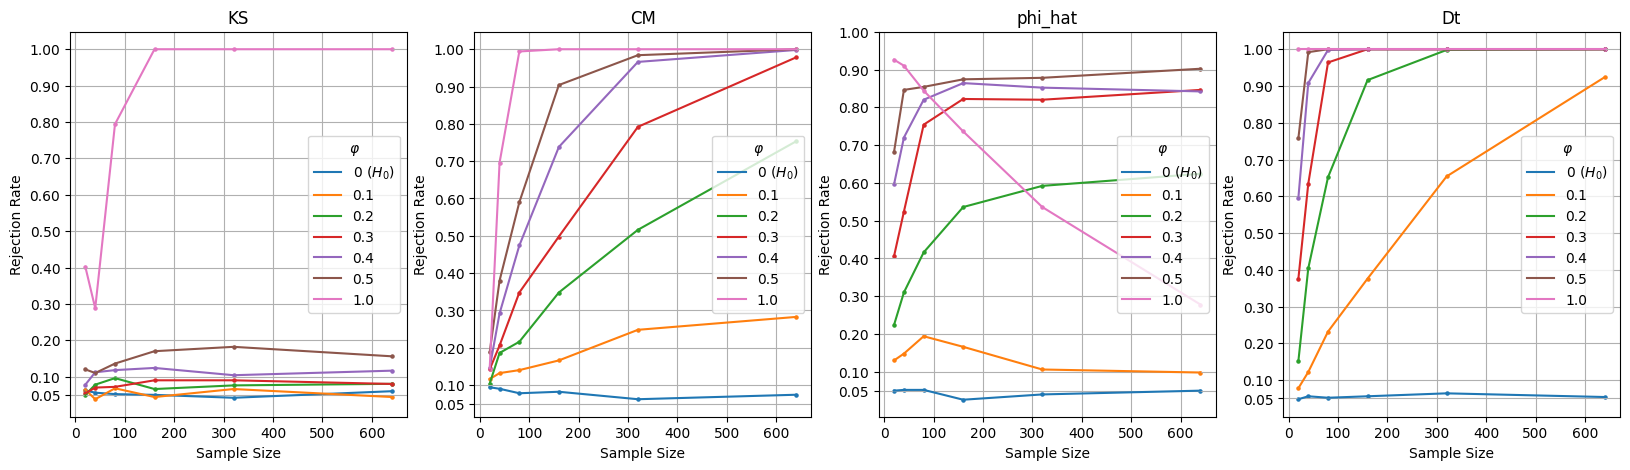

In [105]:
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.title('KS')
plotting.plot_test_for(df_ser_dep_w, 'KS')
plt.subplot(1,4,2)
plt.title('CM')
plotting.plot_test_for(df_ser_dep_w, 'CM')


plt.subplot(1,4,3)
plt.title('phi_hat')
plotting.plot_test_for(df_ours_w, 'phi_hat', onesided=True)
plt.subplot(1,4,4)
plt.title('Dt')
plotting.plot_test_for(df_ours_w, 'Dt')

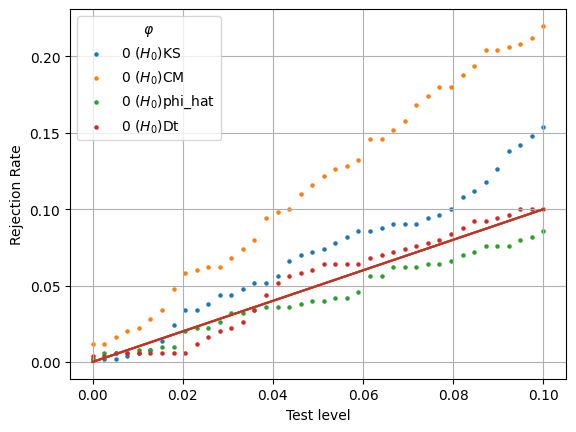

In [155]:
def plot_alpha_alpha(df, statname, samplesize, onesided=False):
    target_sizes = np.linspace(0, 0.1, 40)
    for phi in [0]: # np.sort(df.phi.unique()):
        sub_df = df[(df['sample_size'] == samplesize) & (df['phi'] == phi)]

        emp_sizes = np.zeros_like(target_sizes)
        for i in range(target_sizes.shape[0]):
            alpha=target_sizes[i]

            if onesided:
                crit = compute_critical_val(sub_df, f'quantiles_{statname}', 1-alpha)
                emp_sizes[i] = (sub_df[statname] > crit).mean()
            else:
                crit_lo = compute_critical_val(sub_df, f'quantiles_{statname}', alpha/2)
                crit_hi = compute_critical_val(sub_df, f'quantiles_{statname}', 1 - alpha/2)
                emp_sizes[i] = ((sub_df[statname] < crit_lo) | (sub_df[statname] > crit_hi)).mean()
            
        label = r'$0\ (H_0)$' + statname if phi == 0 else f'{phi:.1f}'
        plt.scatter(target_sizes, emp_sizes, label=label, s=5)

    
    plt.plot(target_sizes,target_sizes)
    plt.legend(title=r'$\varphi$')
    plt.xlabel('Test level')
    plt.ylabel('Rejection Rate')
    plt.grid('on')

samplesize = 320

plot_alpha_alpha(df_ser_dep_w, 'KS', samplesize, onesided=True)
plot_alpha_alpha(df_ser_dep_w, 'CM', samplesize, onesided=True)


plot_alpha_alpha(df_ours_w, 'phi_hat', samplesize, onesided=True)

plot_alpha_alpha(df_ours_w, 'Dt', samplesize)


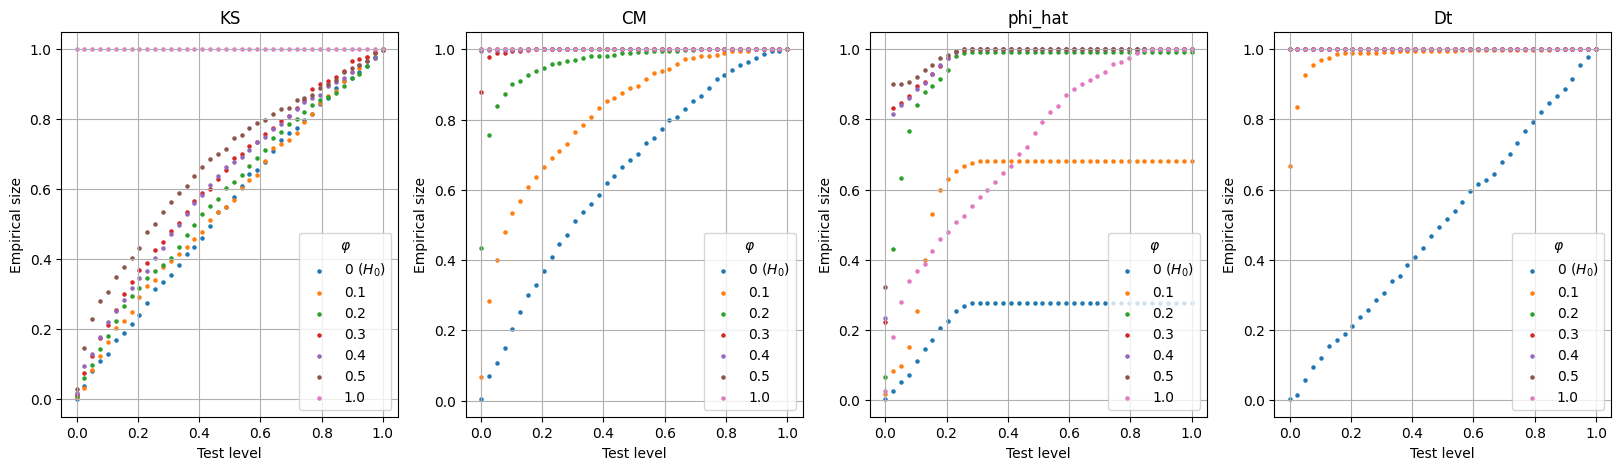

In [163]:

samplesize = 640

plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.title('KS')
plotting.plot_alpha_alpha(df_ser_dep_w, 'KS', samplesize, onesided=True)
plt.subplot(1,4,2)
plt.title('CM')
plotting.plot_alpha_alpha(df_ser_dep_w, 'CM', samplesize, onesided=True)


plt.subplot(1,4,3)
plt.title('phi_hat')
plotting.plot_alpha_alpha(df_ours_w, 'phi_hat', samplesize, onesided=True)
plt.subplot(1,4,4)
plt.title('Dt')
plotting.plot_alpha_alpha(df_ours_w, 'Dt', samplesize)


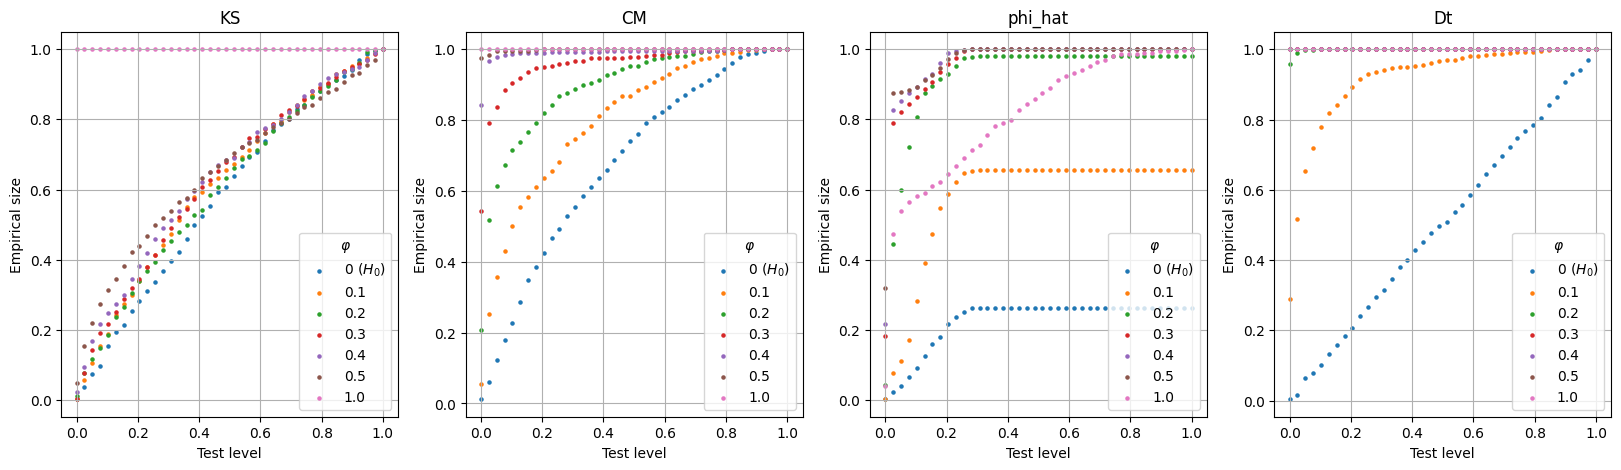

(array([129., 520., 246., 477., 224., 635., 643.,  95.,  30.,   1.]),
 array([ 6. ,  7.6,  9.2, 10.8, 12.4, 14. , 15.6, 17.2, 18.8, 20.4, 22. ]),
 <BarContainer object of 10 artists>)

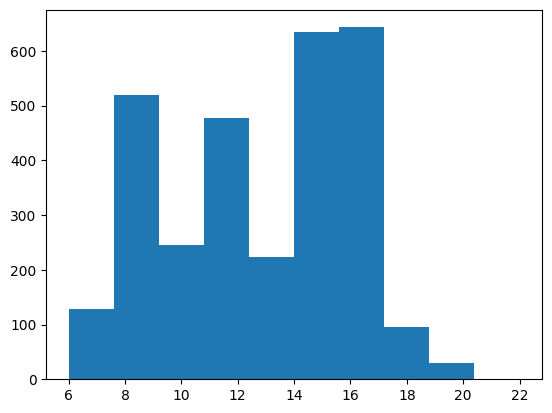

In [141]:
plt.hist(df_ours_r[df_ours_r['phi'] == 0.4].quantiles_phi_hat.apply(lambda q: (q != 0).sum()))

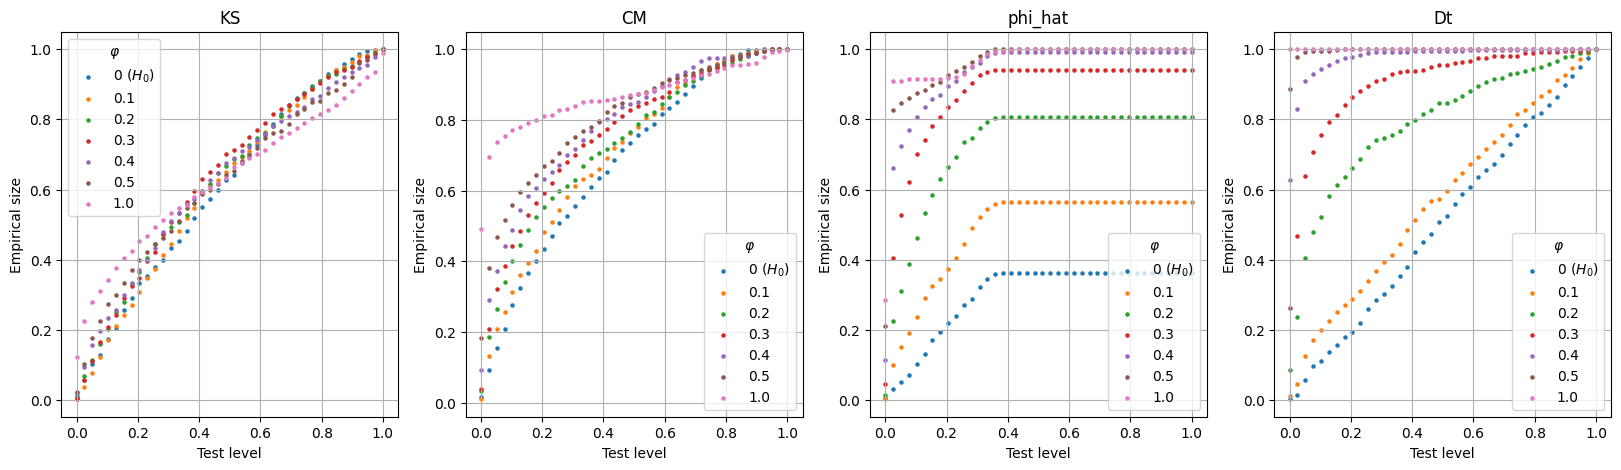

In [109]:
samplesize = 40

plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.title('KS')
plotting.plot_alpha_alpha(df_ser_dep_w, 'KS', samplesize, onesided=True)
plt.subplot(1,4,2)
plt.title('CM')
plotting.plot_alpha_alpha(df_ser_dep_w, 'CM', samplesize, onesided=True)


plt.subplot(1,4,3)
plt.title('phi_hat')
plotting.plot_alpha_alpha(df_ours_w, 'phi_hat', samplesize, onesided=True)
plt.subplot(1,4,4)
plt.title('Dt')
plotting.plot_alpha_alpha(df_ours_w, 'Dt', samplesize)

In [ ]:
df_ours_w

Text(0, 0.5, '$d(\\mu, \\hat\\mu)^2$')

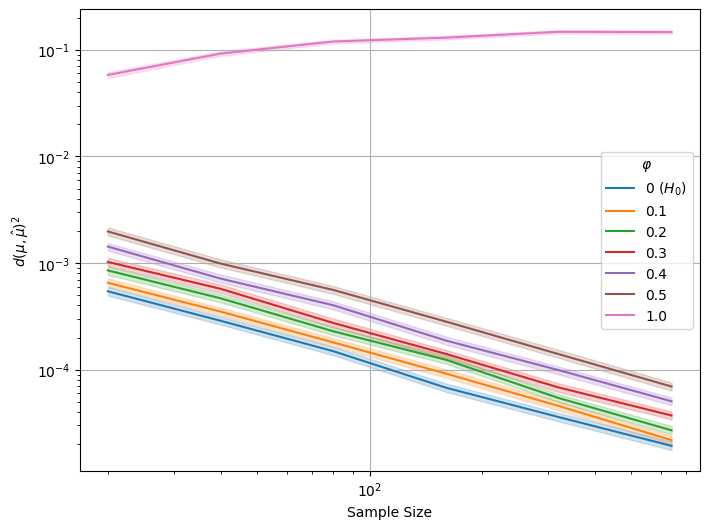

In [37]:
f, ax = plt.subplots(figsize=(8,6))
ax.set(xscale="log", yscale="log")

for phi in np.sort(df_ours_w.phi.unique()):
    # if phi == 1:
    #     continue
    
    sub_df = _df[_df['phi'] == phi]

    label = r'$0\ (H_0)$' if phi == 0 else f'{phi:.1f}'
    sns.lineplot(sub_df, x='sample_size', y='err', label=label)

plt.legend(title=r'$\varphi$')
plt.grid('on')
plt.xlabel('Sample Size')
plt.ylabel(r'$d(\mu, \hat\mu)^2$')

Text(0, 0.5, '$\\left|\\hat\\varphi - \\varphi\\right|$')

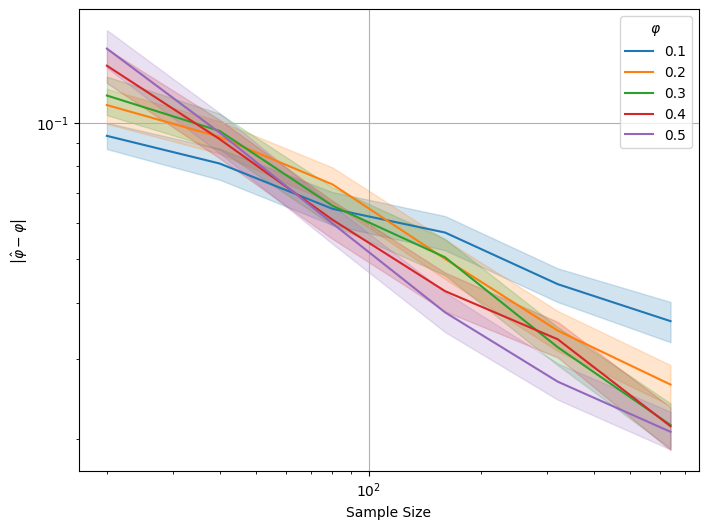

In [157]:
f, ax = plt.subplots(figsize=(8,6))
ax.set(xscale="log", yscale="log")

for phi in np.sort(_df.phi.unique()):
    if phi == 0 or phi == 1:
        # ax.plot([], [], label=r'$0\ (H_0)$')
        continue
    sub_df = _df[_df['phi'] == phi].copy()
    sub_df['err_phi_hat'] = np.abs(sub_df['phi_hat'] - phi) + 1e-20

    label = r'$0\ (H_0)$' if phi == 0 else f'{phi:.1f}'
    sns.lineplot(sub_df, x='sample_size', y='err_phi_hat', label=label, ax=ax)

plt.legend(title=r'$\varphi$')
plt.grid('on')
plt.xlabel('Sample Size')
plt.ylabel(r'$\left|\hat\varphi - \varphi\right|$')

In [155]:
target_T = 100
true_size = np.linspace(0, 1, 40)

for phi in np.sort(_df['phi'].unique()):
    sub_df = _df[(_df['sample_size'] == target_T) & (_df['phi'] == phi)].copy()
    _M = sub_df.shape[0]

    rejection_rate = (np.repeat((np.abs(sub_df['Dt'] - sub_df['boot_mean_Dt']) / sub_df['boot_sig_Dt']).values,true_size.shape[0]).reshape((true_size.shape[0], _M)) > np.repeat(norm.ppf(1 - true_size/2), _M).reshape((true_size.shape[0], _M))).mean(axis=1)

    crit_Dt_lo = compute_critical_val(_df, 'quantiles_Dt', alpha/2)
    crit_Dt_hi = compute_critical_val(_df, 'quantiles_Dt', 1 - alpha/2)

    _df['rejected'] = (_df.Dt < crit_Dt_lo) | (_df.Dt > crit_Dt_hi)


    label = r'$0\ (H_0)$' if phi == 0 else f'{phi:.1f}'
    plt.scatter(true_size, rejection_rate, label=label, s=5)
plt.legend(title=r'$\varphi$')
plt.xlabel('Test level')
plt.ylabel('Empirical size')
plt.grid('on')


KeyError: 'boot_mean_Dt'